In [1]:
import h5py
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gdp
from shapely.affinity import translate

import cartopy.crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
# ASI PRISMA and EO-1 HYPERION
df = pd.DataFrame(
    {'Probe': ['Land', 'Water', 'Wood'],
     'Color': ['#de6b00','#1f78b4','#3FB54B'],
     'Latitude': [-8.61482,-8.7912,-8.7040],
     'Longitude': [116.86549,116.7894,116.8355]})
gdf = gdp.GeoDataFrame(df, crs="EPSG:4326", geometry=gdp.points_from_xy(df.Longitude, df.Latitude))
# sort by label if needed
gdf = gdf.sort_values(by='Probe')
# save to file
gdf.to_file("probs.json", driver="GeoJSON")
gdf

,Probe,Color,Latitude,Longitude,geometry
0,Land,#de6b00,-8.61482,116.86549,POINT (116.86549 -8.61482)
1,Water,#1f78b4,-8.79120,116.78940,POINT (116.78940 -8.79120)
2,Wood,#3FB54B,-8.70400,116.83550,POINT (116.83550 -8.70400)


## Define Metadata

In [3]:
wavelength = [
(435+451)/2, (452+512)/2, (533+590)/2, (636+673)/2, (851+879)/2, (1566+1651)/2,
(2107+2294)/2, (10600+11190)/2, (11500+12510)/2]

## Read Multi-band GeoTiff Dataset (WGS84)

Use gdalbuildvrt tool to produce it from provided multiple GeoTiff files

In [4]:
da = xr.open_rasterio('LANDSAT_LC08_C01_T1_SR_2016_2020.tif')
# scale
#da = da.values/2**14-1
da['band'] = wavelength
#da['fwhm'] = xr.DataArray(fwhm,dims=['band'])
da

<xarray.DataArray (band: 9, y: 1189, x: 1195)>
[12787695 values with dtype=float32]
Coordinates:
  * band     (band) float64 443.0 482.0 561.5 ... 2.2e+03 1.09e+04 1.200e+04
  * y        (y) float64 -8.545 -8.545 -8.545 -8.546 ... -8.864 -8.865 -8.865
  * x        (x) float64 116.7 116.7 116.7 116.7 ... 117.0 117.0 117.0 117.0
Attributes:
    transform:     (0.00026949458523585647, 0.0, 116.71945233857562, 0.0, -0....
    crs:           +init=epsg:4326
    res:           (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:      1
    nodatavals:    (nan, nan, nan, nan, nan, nan, nan, nan, nan)
    scales:        (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:       (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    descriptions:  ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11')

In [5]:
# convert probs to the specified coordinate system
#gdf = gdf.to_crs("EPSG:32750")
#gdf

In [6]:
# bands count
da.band.shape[0]

9

In [7]:
da.band.values

array([  443. ,   482. ,   561.5,   654.5,   865. ,  1608.5,  2200.5,
       10895. , 12005. ])

## LANDSAT/LC08/C01/T1_SR Bands 300m

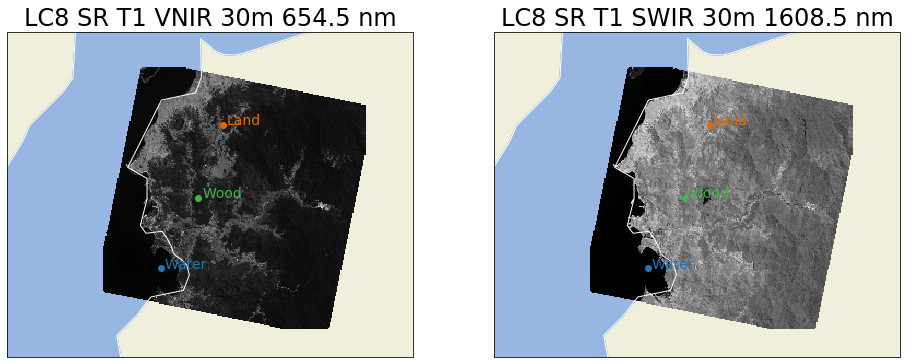

In [8]:
plt.figure(figsize=(16,6))

delta = 0.005

wavelength = 654.5
band_vnir = da.sel(band=wavelength)

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.coastlines(color='white')
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k')
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='lightblue')
ax1.set_global()
band_vnir[::5,::5].plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greys_r", add_colorbar=False)
ax1.set_xlim([116.6,117.1])
ax1.set_ylim([-8.9,-8.5])
ax1.set_title('LC8 SR T1 VNIR 30m %.1f nm' % wavelength,fontsize=24)
# Probs
gdf.apply(lambda x: ax1.annotate(xy=translate(x.loc['geometry'],delta).coords[0],
                                 s=x.Probe, color=x.Color, fontsize=14), axis=1)
gdf.apply(lambda x: ax1.scatter(*x.loc['geometry'].coords[0], c=x.Color), axis=1)

wavelength = 1608.5
band_swir = da.sel(band=wavelength)

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.coastlines(color='white')
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='lightblue')
ax2.set_global()
band_swir[::5,::5].plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(),
                                             cmap="Greys_r", add_colorbar=False)
ax2.set_xlim([116.6,117.1])
ax2.set_ylim([-8.9,-8.5])
ax2.set_title('LC8 SR T1 SWIR 30m %.1f nm' % wavelength,fontsize=24)
# Probs
gdf.apply(lambda x: ax2.annotate(xy=translate(x.loc['geometry'],delta).coords[0],
                                 s=x.Probe, color=x.Color, fontsize=14), axis=1)
gdf.apply(lambda x: ax2.scatter(*x.loc['geometry'].coords[0], c=x.Color), axis=1)

plt.savefig('LANDSAT_LC08_C01_T1_SR VNIR and SWIR Bands.jpg', dpi=150, bbox_inches='tight')
plt.show()

## LANDSAT/LC08/C01/T1_SR Spectrogram of Probe Locations

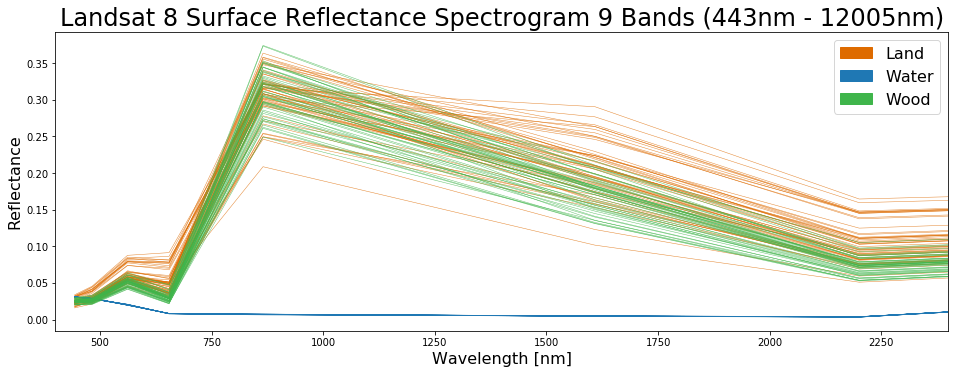

In [9]:
plt.figure(figsize=(16,5.5))
plt.title('Landsat 8 Surface Reflectance Spectrogram %d Bands (%.0fnm - %.0fnm)' %
          (da.band.shape[0],float(da.band.min()),float(da.band.max())),fontsize=24)
ax = plt.gca()

# for manual legend
patches = []
delta = 1e-3

# plot probes
for (idx,row) in gdf.iterrows():
    #print (row.Probe)
    
    probe = row.Probe
    coords = row.geometry.coords[0]
    color = row.Color

    patches.append(mpatches.Patch(color=color, label=probe))
    da_bands_subset = da.sel(x=slice(coords[0]-delta,coords[0]+delta),y=slice(coords[1]+delta,coords[1]-delta))

    bands_subset = da_bands_subset.to_dataframe(name='value').reset_index().dropna()

    ax = plt.gca()
    for key, grp in bands_subset.groupby(['x','y']):
        grp.plot(ax=ax, kind='line', x='band', y='value', color=color,lw=0.5,alpha=0.8)
    ax.get_legend().remove()

plt.legend(handles=patches, loc='upper right', fontsize=16)

plt.xlabel("Wavelength [nm]",size=16)
plt.ylabel("Reflectance",size=16)
plt.xlim([400,2400])
plt.savefig('LANDSAT_LC08_C01_T1_SR Spectrogram VNIR and SWIR Bands.jpg', dpi=150, bbox_inches='tight')
plt.show()